# Regressing Financial Data
**By Jayden Nyamiaka**

In this notebook, we will work with an excel file that contains financial information for a large set of companies for the period 1980-2000s (company-financials.xlsx). The appendix (company-financials-appendix.txt) the labels for each variable.

We will investigate which variables explain (predict) financial leverage, i.e. the amount of debt that companies take on. We will also illustrate how standard errors relate to sampling.

In [86]:
## Import necessary packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [87]:
## Import data
filename = "company-financials.xlsx"
df = pd.read_excel(filename)

## View sample of the data
print(df.head())

   gvkey   datadate    capxv      dltt      dpc     invt  oancf    oiadp  \
0   1045 1980-12-31  431.335  1271.113  233.521  185.081    NaN  -86.253   
1   1045 1981-12-31  542.166  1516.426  233.423  186.065    NaN   72.214   
2   1045 1982-12-31  421.354  1516.609  244.051  193.634    NaN    9.137   
3   1045 1983-12-31  536.039  1511.541  297.188  192.605    NaN  281.484   
4   1045 1984-12-31  516.174  1541.406  307.726  197.521    NaN  368.526   

     ppevbb    ppeveb   pstkrv     sppe   naics   sic     prc  shrout  
0  3459.592  3275.725  125.000    5.864  481111  4512   9.000   28698  
1  3275.725  3781.232  125.000   27.123  481111  4512  11.000   28766  
2  3781.232  4167.129  125.000    4.622  481111  4512  24.750   37241  
3  4167.141  4555.527  254.350   29.459  481111  4512  36.125   48374  
4  4555.512  4626.039  264.038  147.016  481111  4512  36.125   48453  


In [88]:
### Create variables

# Add year column (the year of datadate)
date_col = df['datadate']
def extract_year(date: np.datetime64):
    return date.year
year_col = date_col.apply(extract_year)
df['year'] = year_col

# Add equity column (stock price * number of shares)
df['equity'] = df["prc"] * df["shrout"]

# Add assets column (assets = equity + long-term debt)
df['assets'] = df["equity"] + df["dltt"] * 1000

# Add leverage column (leverage = long-term debt / assets)
df['leverage'] = df["dltt"] * 1000 / df["assets"] 

# Drop all observations with negative stock prices
df.drop(df[df['prc'] < 0].index, inplace=True)

# View sample of transformed dataframe
df.head()

,gvkey,datadate,capxv,dltt,dpc,invt,oancf,oiadp,ppevbb,ppeveb,pstkrv,sppe,naics,sic,prc,shrout,year,equity,assets,leverage
0,1045,1980-12-31,431.335,1271.113,233.521,185.081,NaN,-86.253,3459.592,3275.725,125.000,5.864,481111,4512,9.000,28698,1980,258282.000,1529395.000,0.831121
1,1045,1981-12-31,542.166,1516.426,233.423,186.065,NaN,72.214,3275.725,3781.232,125.000,27.123,481111,4512,11.000,28766,1981,316426.000,1832852.000,0.827359
2,1045,1982-12-31,421.354,1516.609,244.051,193.634,NaN,9.137,3781.232,4167.129,125.000,4.622,481111,4512,24.750,37241,1982,921714.750,2438323.750,0.621988
3,1045,1983-12-31,536.039,1511.541,297.188,192.605,NaN,281.484,4167.141,4555.527,254.350,29.459,481111,4512,36.125,48374,1983,1747510.750,3259051.750,0.463798
4,1045,1984-12-31,516.174,1541.406,307.726,197.521,NaN,368.526,4555.512,4626.039,264.038,147.016,481111,4512,36.125,48453,1984,1750364.625,3291770.625,0.468260


We can observe a few things from our transformed data.
There are 381 unique companies in the dataset.
There are, on average, 22.826771653543307 observations per company.

Let's visualize leverage for companies in 1990:


<Axes: title={'center': 'Leverage for Companies in 1990'}, xlabel='Number of Companies', ylabel='Leverage'>

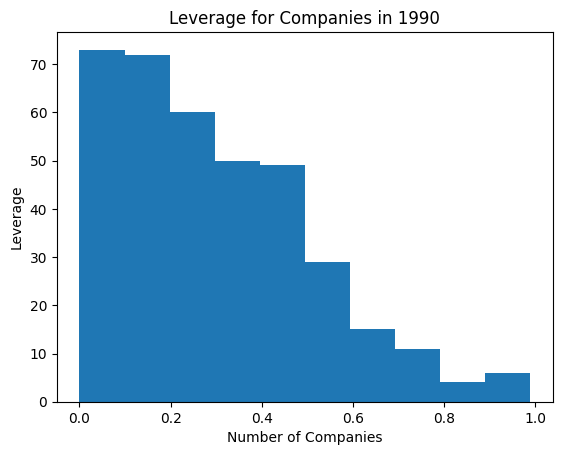

In [89]:
print("We can observe a few things from our transformed data.")

num_unique_companies = df['gvkey'].nunique()
print(f"There are {num_unique_companies} unique companies in the dataset.")

obs_per_company = df['gvkey'].value_counts().mean()
print(f"There are, on average, {obs_per_company} observations per company.")

print("\nLet's visualize leverage for companies in 1990:")
df_1990 = df[df['year'] == 1990]
df_1990['leverage'].plot.hist(xlabel="Number of Companies", ylabel="Leverage", 
                              title="Leverage for Companies in 1990")

We hypothesize that the “model of the world” (CEF) can be linearly approximated by the
following: 

$Leverage _{it} = constant + \beta _1 \log  (CapitalExpenditure) + \beta _2 \log (OperatingIncome _{it}) + controls _{it}$

We will estimate this model using Ordinary Least Squares using heteroskedasticity-robust standard
errors in four different ways:
1. No controls
2. Control variables: Year fixed effects
3. Control variables: Company fixed effects
4. Control variables: Company and Year fixed effects

In [90]:
### Regression estimates, interpretation, and standard errors. Report R-squared.

# Prepare data by removing all rows with no data for the columns we want to regress on
df_reg = df[['capxv','oiadp','leverage', 'year', 'gvkey']].copy()
df_reg['logCapExp'] = np.log(df['capxv'])
df_reg['logOpInc'] = np.log(df['oiadp'])
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg.dropna(inplace=True)

c:\Users\jmtot\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jmtot\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jmtot\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [91]:
# 1. No controls
print("Linear Regression with No Control Variables")
reg1 = smf.ols(formula="leverage ~ logCapExp + logOpInc", data=df_reg).fit(cov_type='HC3')
print(f"R2: {reg1.rsquared}")
print(f"Params: \n{reg1.params}")
print(f"Standard Error: \n{reg1.bse}")
#print(reg1.summary())

Linear Regression with No Control Variables
R2: 0.06714884962353385
Params: 
Intercept    0.253473
logCapExp    0.064518
logOpInc    -0.056463
dtype: float64
Standard Error: 
Intercept    0.008005
logCapExp    0.002830
logOpInc     0.002764
dtype: float64


For this regression, we see the beta coefficients on log(capital expenditure) and log(operating income) are 0.0645 and -0.0565, respectively. This tells us that, on average, for every 1% increase in capital expenditure, the ratio for leverage increases by 0.0645 * ln(1 + 1/100), and for small percent changes, every 1% increase in capital expenditure, the ratio for leverage increases by 0.0645 / 100. Likewise, this also tells us that, on average, for every 1% increase in operating income, the ratio for leverage decreases by 0.056463 * ln(1 + 1/100), and for small percent changes, every 1% increases in operating income, the ratio for leverage decreases by 0.056463 / 100. Additionally, the standard errors for the beta coefficients on log(capital expenditure) and log(operating income) are 0.0028 and 0.0028, respectively. The value of R^2 value is 0.067, revealing a potentially poor correlation.

In [92]:
# 2. Control variables: Year fixed effects
print("\nLinear Regression controlling for Year")
reg2 = smf.ols(formula="leverage ~ logCapExp + logOpInc + C(year)", data=df_reg).fit(cov_type='HC3')
print(f"R2: {reg2.rsquared}")
print(f"Params: \n{reg2.params}")
print(f"Standard Error: \n{reg2.bse}")
#print(reg2.summary())


Linear Regression controlling for Year
R2: 0.07962836714735677
Params: 
Intercept          0.280516
C(year)[T.1981]    0.004855
C(year)[T.1982]    0.011633
C(year)[T.1983]   -0.026305
C(year)[T.1984]   -0.017482
C(year)[T.1985]   -0.043973
C(year)[T.1986]   -0.044483
C(year)[T.1987]   -0.039293
C(year)[T.1988]   -0.028596
C(year)[T.1989]   -0.033585
C(year)[T.1990]   -0.007237
C(year)[T.1991]   -0.039277
C(year)[T.1992]   -0.038666
C(year)[T.1993]   -0.059548
C(year)[T.1994]   -0.041761
C(year)[T.1995]   -0.048740
C(year)[T.1996]   -0.053841
C(year)[T.1997]   -0.074576
C(year)[T.1998]   -0.049859
C(year)[T.1999]   -0.025676
C(year)[T.2000]   -0.009899
C(year)[T.2001]   -0.005053
C(year)[T.2002]    0.018995
C(year)[T.2003]   -0.001745
logCapExp          0.064305
logOpInc          -0.056053
dtype: float64
Standard Error: 
Intercept          0.014496
C(year)[T.1981]    0.017818
C(year)[T.1982]    0.017338
C(year)[T.1983]    0.016997
C(year)[T.1984]    0.016580
C(year)[T.1985]    0.016281

For this regression, we see the beta coefficients on log(capital expenditure) and log(operating income) are 0.064305 and -0.056053, respectively. This tells us that, on average, for every 1% increase in capital expenditure, the ratio for leverage increases by 0.064305 * ln(1 + 1/100), and for small percent changes, every 1% increase in capital expenditure, the ratio for leverage increases by 0.064305 / 100. Likewise, this also tells us that, on average, for every 1% increase in operating income, the ratio for leverage decreases by 0.056053 * ln(1 + 1/100), and for small percent changes, every 1% increase in operating income, the ratio for leverage decreases by 0.056053 / 100. Additionally, the standard errors for the beta coefficients on log(capital expenditure) and log(operating income) are 0.0028 and 0.0028, respectively. The value of R^2 value is 0.080, revealing a potentially poor correlation.

In [93]:
# 3. Control variables: Company fixed effects
print("\nLinear Regression controlling for Company")
reg3 = smf.ols(formula="leverage ~ logCapExp + logOpInc + C(gvkey)", data=df_reg).fit(cov_type='HC3')
print(f"R2: {reg3.rsquared}")
print(f"Coefficients: \n{reg3.params}")
print(f"Standard Error: \n{reg3.bse}")
#print(reg3.summary())


Linear Regression controlling for Company
R2: 0.7047344218135714
Coefficients: 
Intercept            0.524744
C(gvkey)[T.1075]     0.064843
C(gvkey)[T.1161]    -0.417744
C(gvkey)[T.1209]    -0.253197
C(gvkey)[T.1230]    -0.040751
                       ...   
C(gvkey)[T.15247]   -0.052796
C(gvkey)[T.23769]   -0.268110
C(gvkey)[T.28590]   -0.377676
logCapExp            0.016577
logOpInc            -0.025805
Length: 383, dtype: float64
Standard Error: 
Intercept            0.034348
C(gvkey)[T.1075]     0.039264
C(gvkey)[T.1161]     0.034128
C(gvkey)[T.1209]     0.031286
C(gvkey)[T.1230]     0.048191
                       ...   
C(gvkey)[T.15247]    0.048640
C(gvkey)[T.23769]    0.045319
C(gvkey)[T.28590]    0.034604
logCapExp            0.002901
logOpInc             0.002771
Length: 383, dtype: float64


For this regression, we see the beta coefficients on log(capital expenditure) and log(operating income) are 0.064305 and -0.056053, respectively. This tells us that, on average, for every 1% increase in capital expenditure, the ratio for leverage increases by 0.016577 * ln(1 + 1/100), and for small percent changes, every 1% increase in capital expenditure, the ratio for leverage increases by 0.016577 / 100. Likewise, this also tells us that, on average, for every 1% increase in operating income, the ratio for leverage decreases by 0.025805 * ln(1 + 1/100), and for small percent changes, every 1% increase in operating income, the ratio for leverage decreases by 0.025805 / 100. Additionally, the standard errors for the beta coefficients on log(capital expenditure) and log(operating income) are 0.0029 and 0.0028, respectively. The value of R^2 value is 0.705, revealing a potentially strong correlation.

In [94]:
# 4) Control variables: Company and Year fixed effect
print("\nLinear Regression controlling for Company and Year")
reg4 = smf.ols(formula="leverage ~ logCapExp + logOpInc + C(gvkey) + C(year)", data=df_reg).fit(cov_type='HC3')
print(f"R2: {reg4.rsquared}")
print(f"Params: \n{reg4.params}")
print(f"Standard Error: \n{reg4.bse}")
#print(reg4.summary())


Linear Regression controlling for Company and Year
R2: 0.7187825021463716
Params: 
Intercept           0.545753
C(gvkey)[T.1075]    0.061060
C(gvkey)[T.1161]   -0.422774
C(gvkey)[T.1209]   -0.258467
C(gvkey)[T.1230]   -0.036914
                      ...   
C(year)[T.2001]    -0.007592
C(year)[T.2002]     0.009021
C(year)[T.2003]    -0.016848
logCapExp           0.017257
logOpInc           -0.023360
Length: 406, dtype: float64
Standard Error: 
Intercept           0.035520
C(gvkey)[T.1075]    0.038173
C(gvkey)[T.1161]    0.033153
C(gvkey)[T.1209]    0.029468
C(gvkey)[T.1230]    0.048238
                      ...   
C(year)[T.2001]     0.012749
C(year)[T.2002]     0.012752
C(year)[T.2003]     0.012492
logCapExp           0.002956
logOpInc            0.003129
Length: 406, dtype: float64


For this regression, we see the beta coefficients on log(capital expenditure) and log(operating income) are 0.064305 and -0.056053, respectively. This tells us that, on average, for every 1% increase in capital expenditure, the ratio for leverage increases by 0.017257 * ln(1 + 1/100), and for small percent changes, every 1% increase in capital expenditure, the ratio for leverage increases by 0.017257 / 100. Likewise, this also tells us that, on average, for every 1% increase in operating income, the ratio for leverage decreases by 0.023360 * ln(1 + 1/100), and for small percent changes, every 1% increase in operating income, the ratio for leverage decreases by 0.023360 / 100. Additionally, the standard errors for the beta coefficients on log(capital expenditure) and log(operating income) are 0.0030 and 0.0031, respectively. The value of R^2 value is 0.719, revealing a potentially strong correlation.

Standard Deviation for the Intercept is 0.043969007627680676.


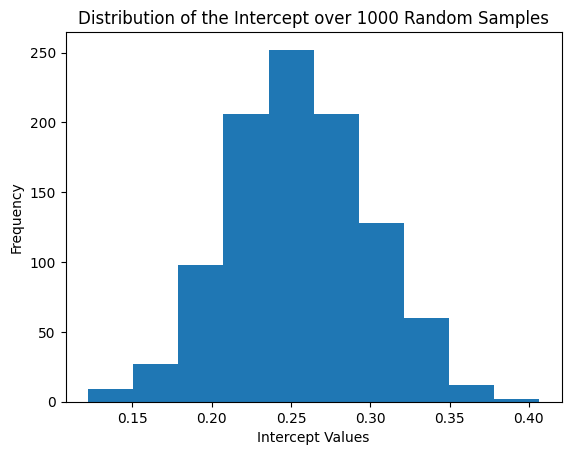

Standard Deviation for Beta 1 is 0.012381020973511667.


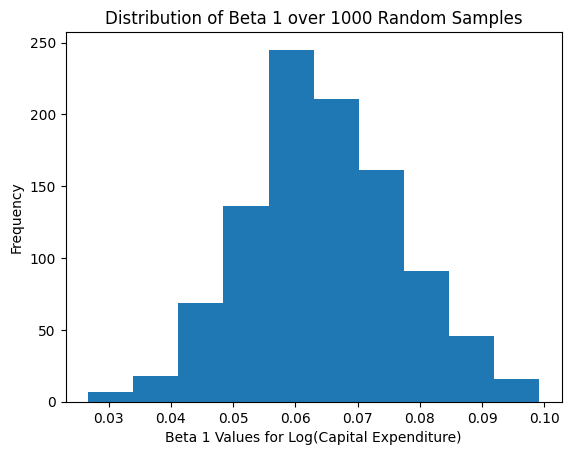

Standard Deviation for the Beta 2 is 0.011903421836896742.


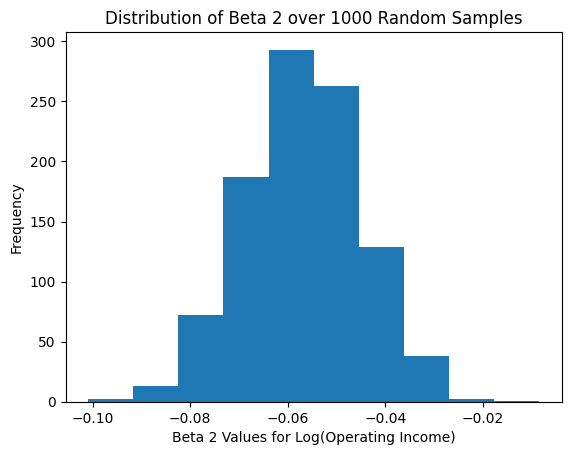

In [95]:
## 1000 Random samples and 1000 regression results (100 companies in each sample). Plot distribution of each beta coefficient.
## Compare standard deviation of each distribution to standard error of regression (4) from the previous part.
samples = 1000
companies_per_sample = 100
intercepts = []
beta1s = []
beta2s = []

all_companies = list(df_reg['gvkey'].value_counts().index)
for i in range(samples):
    comp_sample = random.sample(all_companies, companies_per_sample)
    df_sample = df_reg[df_reg['gvkey'].isin(comp_sample)]
    reg = smf.ols(formula="leverage ~ logCapExp + logOpInc", data=df_sample).fit(cov_type='HC3')
    coefs = reg.params
    intercepts.append(coefs.iloc[0])
    beta1s.append(coefs.iloc[1])
    beta2s.append(coefs.iloc[2])


print(f"Standard Deviation for the Intercept is {np.std(intercepts)}.")
plt.hist(intercepts)
plt.xlabel("Intercept Values")
plt.ylabel("Frequency")
plt.title("Distribution of the Intercept over 1000 Random Samples")
plt.show()

print(f"Standard Deviation for Beta 1 is {np.std(beta1s)}.")
plt.hist(beta1s)
plt.xlabel("Beta 1 Values for Log(Capital Expenditure)")
plt.ylabel("Frequency")
plt.title("Distribution of Beta 1 over 1000 Random Samples")
plt.show()

print(f"Standard Deviation for the Beta 2 is {np.std(beta2s)}.")
plt.hist(beta2s)
plt.xlabel("Beta 2 Values for Log(Operating Income)")
plt.ylabel("Frequency")
plt.title("Distribution of Beta 2 over 1000 Random Samples")
plt.show()

## Comparison
We see that standard errors from the 4th regression in the last part are 0.0355, 0.0030, and 0.0031 for the Intercept, Beta 1, and Beta 2, respectively. While the standard deviations from our 1000 random samples are about 0.04, 0.013, and 0.011. We see that the standard errors for our beta coefficients in the regression is much less than our standard deviation from the 1000 random sampling. 